In [15]:
import re
import nltk
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.svm import SVC
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [16]:
# Load the AG News Dataset
train_df = pd.read_csv('C:/Users/Mike Francis/PycharmProjects/news_article_classification/data/raw/train.csv')
test_df = pd.read_csv('C:/Users/Mike Francis/PycharmProjects/news_article_classification/data/raw/test.csv')

In [17]:
test_df.head()

,Class Index,Title,Description
0,3,Fears for T N pension after talks,Unions representing workers at Turner Newall...
1,4,The Race is On: Second Private Team Sets Launc...,"SPACE.com - TORONTO, Canada -- A second\team o..."
2,4,Ky. Company Wins Grant to Study Peptides (AP),AP - A company founded by a chemistry research...
3,4,Prediction Unit Helps Forecast Wildfires (AP),AP - It's barely dawn when Mike Fitzpatrick st...
4,4,Calif. Aims to Limit Farm-Related Smog (AP),AP - Southern California's smog-fighting agenc...


In [18]:
train_df.head()

,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


# **VISUALISATION**
### 1. Class Distribution

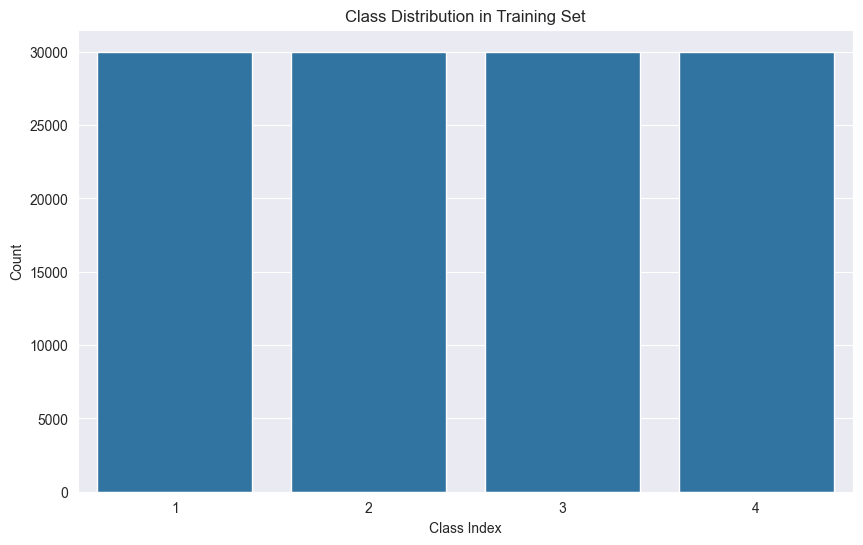

In [19]:
# Plot the class distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='Class Index', data=train_df)
plt.title('Class Distribution in Training Set')
plt.xlabel('Class Index')
plt.ylabel('Count')
plt.show()


## 2. Text Length Distribution

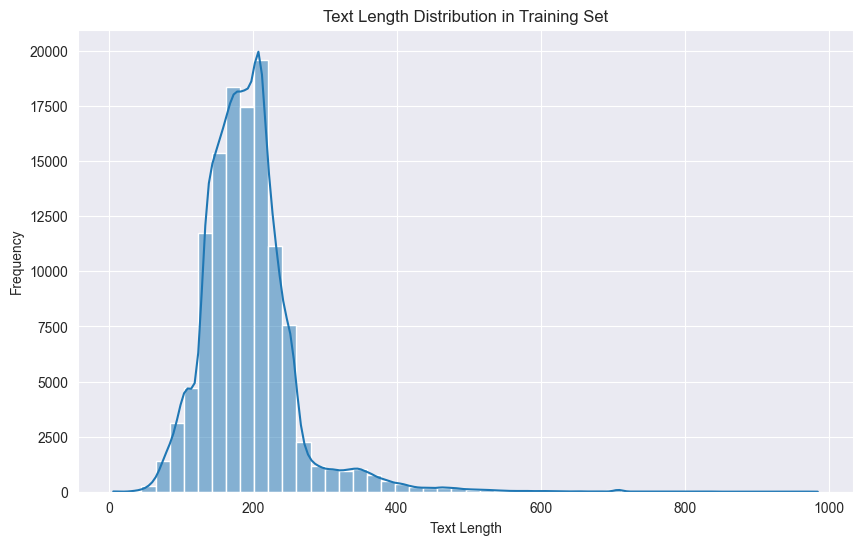

In [20]:
# Calculate the length of each description
train_df['text_length'] = train_df['Description'].apply(len)

# Plot the text length distribution
plt.figure(figsize=(10, 6))
sns.histplot(train_df['text_length'], bins=50, kde=True)
plt.title('Text Length Distribution in Training Set')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()


### 3. Word Cloud

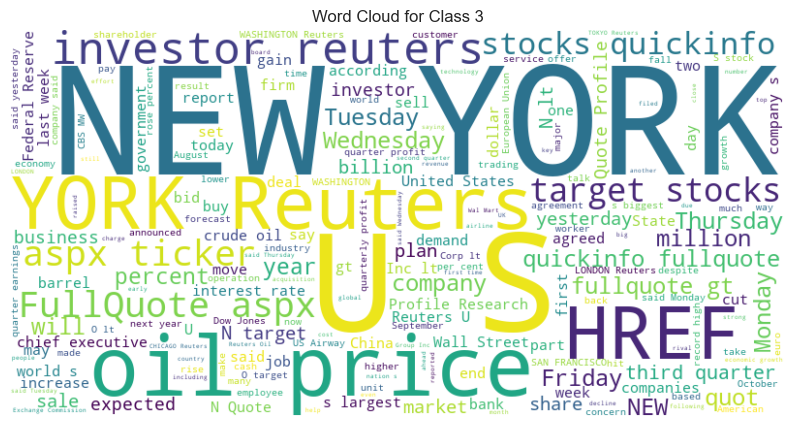

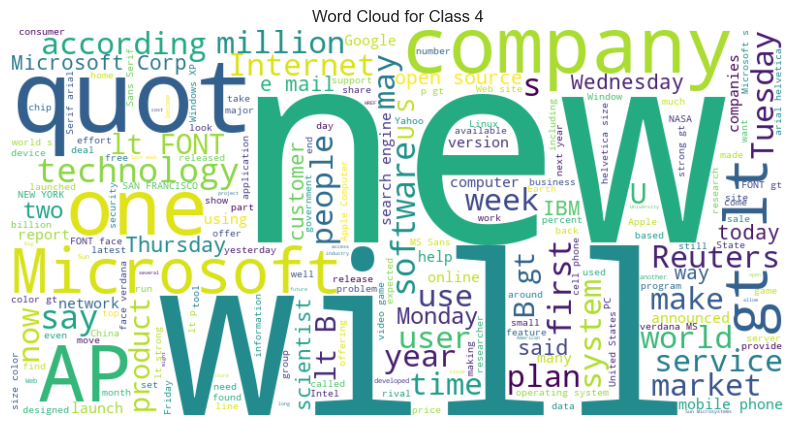

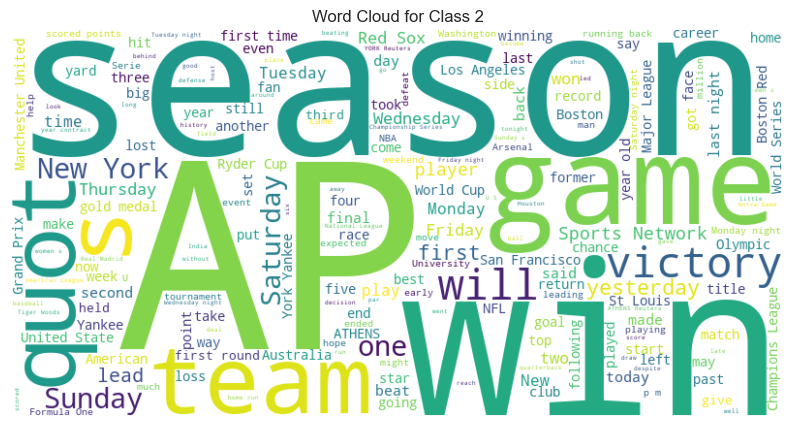

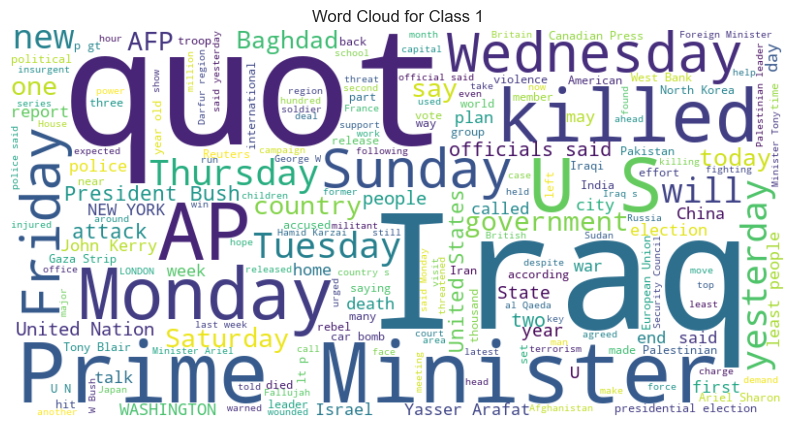

In [21]:
# Generate word cloud for each class
for class_index in train_df['Class Index'].unique():
    class_data = train_df[train_df['Class Index'] == class_index]
    text = ' '.join(class_data['Description'])

    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for Class {class_index}')
    plt.axis('off')
    plt.show()


In [22]:
test_df.head()

,Class Index,Title,Description
0,3,Fears for T N pension after talks,Unions representing workers at Turner Newall...
1,4,The Race is On: Second Private Team Sets Launc...,"SPACE.com - TORONTO, Canada -- A second\team o..."
2,4,Ky. Company Wins Grant to Study Peptides (AP),AP - A company founded by a chemistry research...
3,4,Prediction Unit Helps Forecast Wildfires (AP),AP - It's barely dawn when Mike Fitzpatrick st...
4,4,Calif. Aims to Limit Farm-Related Smog (AP),AP - Southern California's smog-fighting agenc...


In [23]:
test_df.tail()

,Class Index,Title,Description
7595,1,Around the world,Ukrainian presidential candidate Viktor Yushch...
7596,2,Void is filled with Clement,With the supply of attractive pitching options...
7597,2,Martinez leaves bitter,Like Roger Clemens did almost exactly eight ye...
7598,3,5 of arthritis patients in Singapore take Bext...,SINGAPORE : Doctors in the United States have ...
7599,3,EBay gets into rentals,EBay plans to buy the apartment and home renta...


In [24]:
train_df.tail()

,Class Index,Title,Description,text_length
119995,1,Pakistan's Musharraf Says Won't Quit as Army C...,KARACHI (Reuters) - Pakistani President Perve...,170
119996,2,Renteria signing a top-shelf deal,Red Sox general manager Theo Epstein acknowled...,274
119997,2,Saban not going to Dolphins yet,The Miami Dolphins will put their courtship of...,215
119998,2,Today's NFL games,PITTSBURGH at NY GIANTS Time: 1:30 p.m. Line: ...,352
119999,2,Nets get Carter from Raptors,INDIANAPOLIS -- All-Star Vince Carter was trad...,195


In [25]:
print(test_df.columns)

Index(['Class Index', 'Title', 'Description'], dtype='object')


In [26]:
print(train_df.columns)

Index(['Class Index', 'Title', 'Description', 'text_length'], dtype='object')


In [27]:
print(train_df.shape)
print(test_df.shape)

(120000, 4)
(7600, 3)


In [28]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Preprocess the data
def preprocess_text(text):
    text = re.sub(r'<[^>]+>', '', text)
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    text = text.lower()
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# Preprocess the text data in the training and testing datasets
train_df['cleaned_text'] = train_df['Description'].apply(preprocess_text)
test_df['cleaned_text'] = test_df['Description'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to C:\Users\Mike
[nltk_data]     Francis\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [29]:
# Vectorize the text data
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(train_df['cleaned_text'])
X_test_tfidf = vectorizer.transform(test_df['cleaned_text'])
y_train = train_df['Class Index']
y_test = test_df['Class Index']


In [31]:
# Save the vectorizer
joblib.dump(vectorizer, 'C:/Users/Mike Francis/PycharmProjects/news_article_classification/models/tfidf_vectorizer.pkl')

['C:/Users/Mike Francis/PycharmProjects/news_article_classification/models/tfidf_vectorizer.pkl']

In [32]:
# Logistic Regression
lr_model = make_pipeline(StandardScaler(with_mean=False), LogisticRegression(max_iter=1000))
lr_model.fit(X_train_tfidf, y_train)

# Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)

# Support Vector Machine
svm_model = make_pipeline(StandardScaler(with_mean=False), SVC())
svm_model.fit(X_train_tfidf, y_train)

Pipeline(steps=[('standardscaler', StandardScaler(with_mean=False)),
                ('svc', SVC())])

In [35]:
# Evaluate the models
models = {
    'Logistic Regression': lr_model,
    'Naive Bayes': nb_model,
    'SVM': svm_model
}

accuracies = {}

for model_name, model in models.items():
    y_pred = model.predict(X_test_tfidf)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    matrix = confusion_matrix(y_test, y_pred)
    
    accuracies[model_name] = accuracy
    
    print(f"{model_name} Accuracy: {accuracy}")
    print(f"{model_name} Classification Report:\n{report}")
    print(f"{model_name} Confusion Matrix:\n{matrix}")
    print("\n")

Logistic Regression Accuracy: 0.8768421052631579
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           1       0.88      0.87      0.88      1900
           2       0.93      0.93      0.93      1900
           3       0.84      0.84      0.84      1900
           4       0.85      0.86      0.85      1900

    accuracy                           0.88      7600
   macro avg       0.88      0.88      0.88      7600
weighted avg       0.88      0.88      0.88      7600

Logistic Regression Confusion Matrix:
[[1661   69   96   74]
 [  77 1774   28   21]
 [  81   24 1604  191]
 [  60   36  179 1625]]


Naive Bayes Accuracy: 0.8767105263157895
Naive Bayes Classification Report:
              precision    recall  f1-score   support

           1       0.89      0.88      0.88      1900
           2       0.93      0.96      0.95      1900
           3       0.85      0.82      0.83      1900
           4       0.84      0.85      0.84    

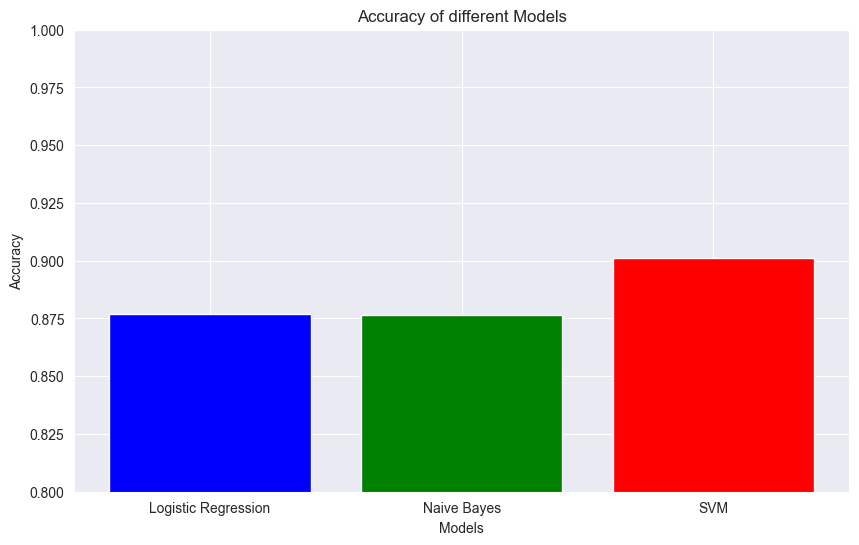

In [36]:
# Plotting the accuracies
plt.figure(figsize=(10, 6))
plt.bar(accuracies.keys(), accuracies.values(), color=['blue','green','red'])
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Accuracy of different Models')
plt.ylim([0.8, 1])
plt.show()


In [34]:
# Save the Logistic Regression model
joblib.dump(lr_model, 'logistic_regression_model.pkl')

# Save the Naive Bayes model
joblib.dump(nb_model, 'naive_bayes_model.pkl')

# Save the SVM model
joblib.dump(svm_model, 'svm_model.pkl')

# Save the TF-IDF vectorizer
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')


['tfidf_vectorizer.pkl']